## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("2.2.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 806.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=062cfcc75ab794b7d1f3ae36e9b7df570468bb95587f561cb84775f1908e1f20
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=02a41e7772bb46e20cc8f05d70e1b9e739286772476bcf6a374945eb5504d05f
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt221/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 46.3 MB/s eta 0:00:00


In [2]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere, torus
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

## 1. Load an obj file and create a Meshes object

Download the target 3D model of a dolphin. It will be saved locally as a file called `dolphin.obj`.

In [37]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2024-05-07 03:09:17--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.82, 13.35.7.50, 13.35.7.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj.1’

dolphin.obj.1       100%[===================>] 153.09K  --.-KB/s    in 0.008s  

2024-05-07 03:09:17 (19.4 MB/s) - ‘dolphin.obj.1’ saved [156763/156763]



In [4]:
# Load the dolphin mesh.
trg_obj = os.path.join('dolphin.obj')

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


1.1 The source mesh is a sphere of radius 1 centered at (0, 0, 0). To speed up the optimization process, we should scale normalize the target mesh and center it at the origin, making it fit the unit sphere. Do this operations with the `verts`tensor and create a `Meshes` object called "trg_mesh" with the normalized vertices and the faces indices.

1.2 Visualize the source and target meshes using `Plotly` integration.

In [5]:
import plotly.graph_objects as go

In [6]:
##############################################################################
# Code for 1.1 - 1.2
##############################################################################
max_distance = 0

def visualize_mesh(mesh, color='lightblue'):
    # Extract vertices and faces from the Meshes object
    vertices = mesh.verts_list()[0].detach().cpu().numpy()
    faces = mesh.faces_list()[0].detach().cpu().numpy()

    # Create a Plotly mesh3d object
    mesh3d = go.Mesh3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
                       i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                       color=color, opacity=0.5,)
    return mesh3d

def normalize_mesh(verts, faces_idx):
   # get centroid, translate verts to origin, then scale mesh by the largest distance from origin
   global max_distance
   centroid = verts.mean(dim=0)
   verts_centered = verts - centroid
   max_distance = torch.max(torch.norm(verts_centered, dim=1))
   verts_normalized = verts_centered / max_distance
   trg_mesh = Meshes(verts=[verts_normalized], faces=[faces_idx])
   return trg_mesh

def plotly_figure(*mesh3d):
   fig = go.Figure()
   for v_mesh in mesh3d:
     fig.add_trace(v_mesh)
   fig.update_layout(scene=dict(aspectmode='data'))
   fig.show()


trg_mesh = normalize_mesh(verts, faces_idx)
plotly_figure(visualize_mesh(src_mesh, color='lightblue'), visualize_mesh(trg_mesh, color='lightgreen'))

###  Visualizing point clouds with Matplotlib

We can also sample points from the surfaces and visualize them using Matplotlib. It can be a useful to have a coarse estimation of the surface during iterations in the optimization process.

In [7]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

1.3 Use the function `plot_pointcloud` to see the initial pointcloud

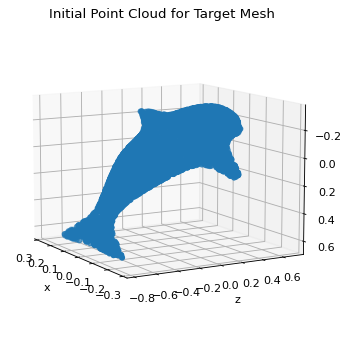

In [8]:
%matplotlib inline
##############################################################################
# Code for 1.3
##############################################################################
plot_pointcloud(trg_mesh, title="Initial Point Cloud for Target Mesh")

## 2. Optimization loop

Starting from a sphere mesh, we learn the offset to each vertex in the mesh such that the predicted mesh is closer to the target mesh at each optimization step. To achieve this we minimize the distance between the predicted (deformed) and target mesh, defined as the **chamfer distance** between the set of pointclouds resulting from **differentiably sampling points** from their surfaces.

However, solely minimizing the chamfer distance between the predicted and the target mesh will lead to a non-smooth shape. We enforce smoothness by adding **shape regularizers** to the objective. Namely, we add:

+ `mesh_edge_length`, which minimizes the length of the edges in the predicted mesh.
+ `mesh_normal_consistency`, which enforces consistency across the normals of neighboring faces.
+ `mesh_laplacian_smoothing`, which is the laplacian regularizer.
We will learn to deform the source mesh by offsetting its vertices

In [9]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [13]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
src_mesh = ico_sphere(4, device)


OBS: Note that you need the "trg_mesh" from 1.1 for the optimization code to work.

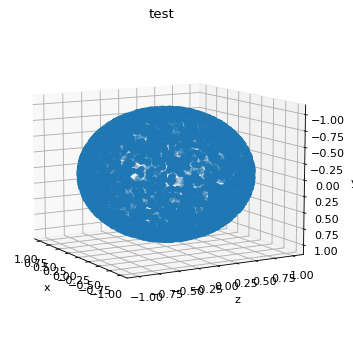

In [14]:
plot_pointcloud(src_mesh, title='test')

In [48]:
new_src_mesh = None
sgd, adam, rmsprop, sgd_second = 'sgd', 'adam', 'rmsprop', 'other'
sphere_style, torus_stye, other_shape = 'sphere', 'torus', 'other'
def optimization_loop(Niter = 4000, w_chamfer = 1.0, w_edge = 1.0, w_normal = 0.01, w_laplacian = 0.1, optimizer_style=sgd, src_mesh_style=sphere_style):
  global new_src_mesh
  if src_mesh_style == sphere_style:
    src_mesh = ico_sphere(4, device)
  elif src_mesh_style == torus_stye:
    src_mesh = torus(0.5, 1, 30, 20, device)
  else: # other_shape
    verts, faces, _ = load_obj(os.path.join('dolphin.obj'))
    faces_idx = faces.verts_idx.to(device)
    verts = verts.to(device)
    src_mesh = normalize_mesh(verts, faces_idx)
  deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
  if optimizer_style == sgd:
    optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
  elif optimizer_style == adam:
    optimizer = torch.optim.Adam([deform_verts], lr=0.001)
  elif optimizer_style == rmsprop:
    optimizer = optimizer = torch.optim.RMSprop([deform_verts], lr=0.01, momentum=0.9)
  else: # SGD with Different Learning Rate and Momentum:
    optimizer = torch.optim.SGD([deform_verts], lr=0.1, momentum=0.5)

  plot_period = 250
  loop = tqdm(range(Niter))
  chamfer_losses, laplacian_losses, edge_losses, normal_losses = [], [], [], []

  %matplotlib inline

  for i in loop:
      # Initialize optimizer
      optimizer.zero_grad()

      # Deform the mesh
      new_src_mesh = src_mesh.offset_verts(deform_verts)

      # We sample 5k points from the surface of each mesh
      sample_trg = sample_points_from_meshes(trg_mesh, 5000)
      sample_src = sample_points_from_meshes(new_src_mesh, 5000)

      # We compare the two sets of pointclouds by computing (a) the chamfer loss
      loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

      # and (b) the edge length of the predicted mesh
      loss_edge = mesh_edge_loss(new_src_mesh)

      # mesh normal consistency
      loss_normal = mesh_normal_consistency(new_src_mesh)

      # mesh laplacian smoothing
      loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

      # Weighted sum of the losses
      loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

      # Print the losses
      loop.set_description('total_loss = %.6f' % loss)

      # Save the losses for plotting
      chamfer_losses.append(float(loss_chamfer.detach().cpu()))
      edge_losses.append(float(loss_edge.detach().cpu()))
      normal_losses.append(float(loss_normal.detach().cpu()))
      laplacian_losses.append(float(loss_laplacian.detach().cpu()))

      # Plot mesh
      if i % plot_period == 0:
          plot_pointcloud(new_src_mesh, title="iter: %d" % i)

      # Optimization step
      loss.backward()
      optimizer.step()

  return chamfer_losses, laplacian_losses, edge_losses, normal_losses

  0%|          | 0/2000 [00:00<?, ?it/s]

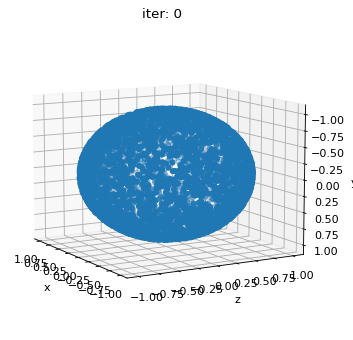

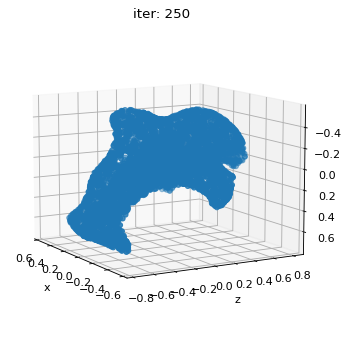

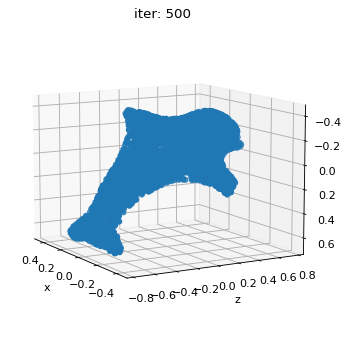

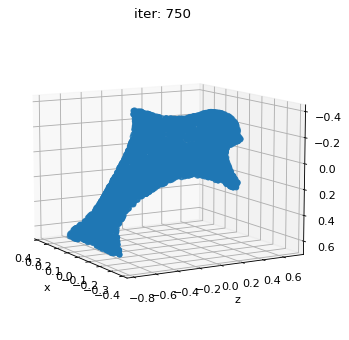

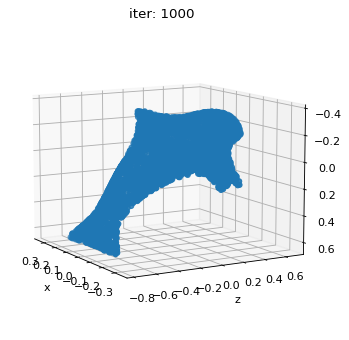

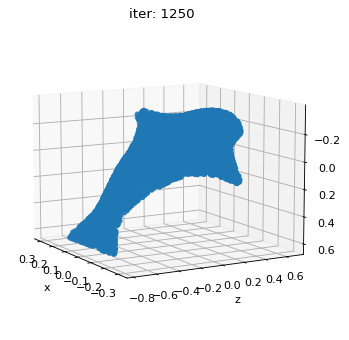

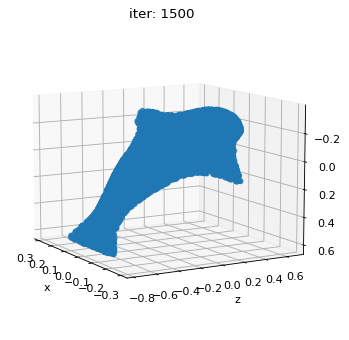

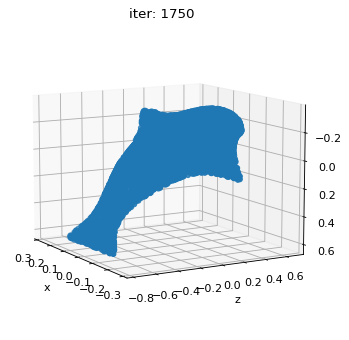

In [20]:
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(2000)

## Visualize the loss

In [ ]:
def plot_losses(loss_dict, size=(13,5)):
  fig = plt.figure(figsize=size)
  ax = fig.gca()
  for loss_name, loss_values in loss_dict.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

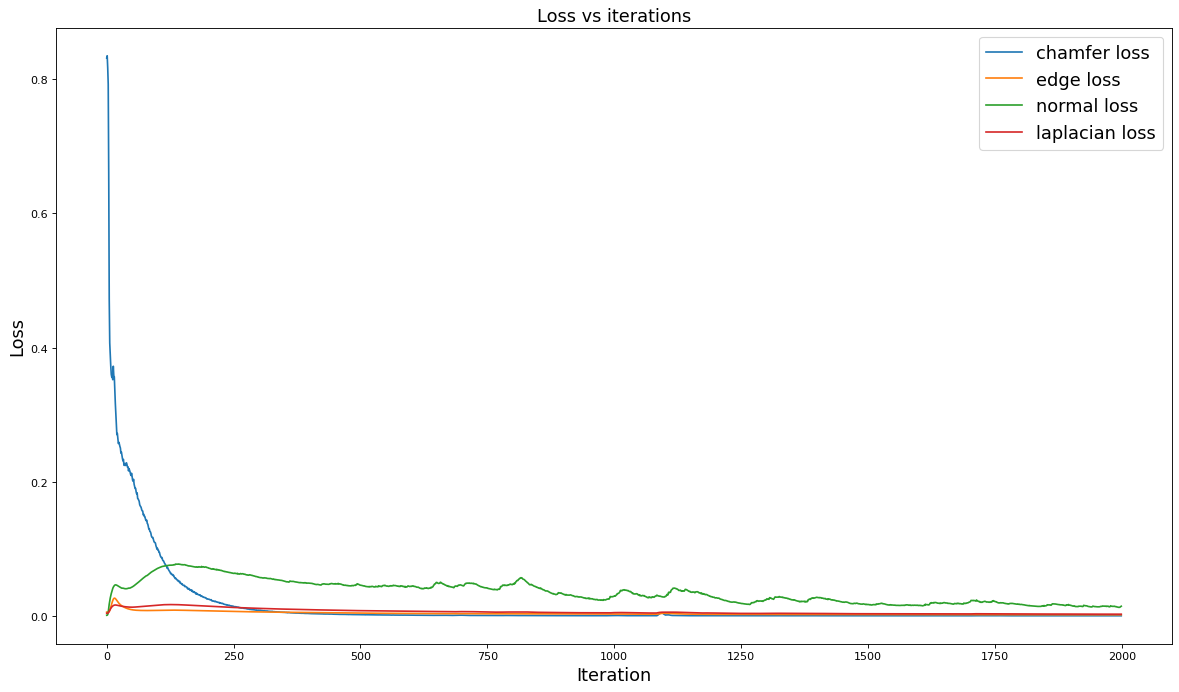

In [ ]:
losses = {"chamfer loss": chamfer_losses,
          "edge loss": edge_losses,
          "normal loss": normal_losses,
          "laplacian loss": laplacian_losses}
plot_losses(losses, (18, 10))

## Save the predicted mesh

In [21]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

2.1 Scale normalize back the `final_verts` to the original target size



In [24]:
##############################################################################
# Code for 2.1
##############################################################################
original_size_final_verts = final_verts * max_distance
final_mesh = Meshes(verts=[original_size_final_verts], faces=[final_faces])
plotly_figure(visualize_mesh(final_mesh, color='lightblue'), visualize_mesh(trg_mesh, color='lightgreen'))

In [ ]:
# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

2.2 Visualize the target mesh and the final mesh using `Plotly`. Qualitatively, what do you think of the result?

2.3 Take a look at the **Loss vs Iteration** graph, paying attention to how the losses are decreasing. Do you think it would be possible to achieve a reasonable result with less iterations? Is it worth to run with more iterations? Explain you thoughts, then run the optimization loop again making the changes to validate your hypothesis.

2.4 The loss function used for this task is a linear combination of four losses. Let `w_chamfer = 1.0` and set the other coefficients to zero. Run the  optimization loop again with this configuration and describe the result.

**[EXTRA] E.1 Experiment other coefficients configurations and describe the results.**

2.5 Experiment with others optimizers such as `Adam` and `RMSprop` in place of `SGD`. Also, try changing the learning rate (`lr`), and `momentum` when these parameters are applied. What do you observe in terms of speed of convergence and quality of final results?




### Answers for 2

2.2: Qualitatively, the target mesh and final mesh are very similar. However, the final mesh still looks a bit deformed compared to the sharpness in the target mesh


2.3: The key observation is that the rate of decreasing loss significantly decreases after 1000 iterations.

Achieving a "reasonable" result depends on the definition of "reasonable" in this context. If the goal is to achieve a visually convincing result that closely resembles a dolphin mesh, then it can be argued that further iterations may not lead to significant improvements beyond a certain point. It is also possible to get a reasonable result with less iterations, as we can see that 1000 iterations already looks convincingly like the dolphin.

However, if the goal is to achieve a highly accurate deformation with minimal deviation from the target mesh, then running more iterations might still be beneficial, although possibly with diminishing returns.

I tried with 4000 iterations and there was no visual difference with 2000 iterations.


2.4.By setting the coefficients of the other losses to zero and only considering the chamfer distance loss (w_chamfer = 1.0), we effectively prioritize minimizing the distance between the predicted and target meshes without enforcing any smoothness constraints. This means that the optimization process will focus solely on aligning the vertices of the predicted mesh with those of the target mesh, without considering factors such as edge length, normal consistency, or laplacian smoothing. We have increase deformation and less smoothness, which is seen as a result.

2.4.Extension. I tried many different configurations and I will discuss here:

- High Weight on Chamfer Distance, Low Weights on Others: Results in similar shape, but much the shape is very sharp and not smooth at all.

- High weight on smoothness constraints: It makes almost like a blob that somewhat resembles the target shape, but is too smooth and resulting in loss of features.

- Weighted Emphasis on Edge Length and Laplacian Smoothing: more regular edge lengths and vertex distribution. However, the resulting mesh deviates slightly from the exact shape of the target mesh.

2.5.

Adam optimizer is known for its adaptive learning rate and can converge faster than SGD.Adam is prett good, and has smoother convergence.

RMSprop is also an adaptive learning rate optimizer but differs from Adam in terms of its update rule. Rmsprop is giving a balanced convergence speed but seems to be less in quality.

Modifying learning rate and momentum affects the convergence speed and stability. With much less learning rate and momentum, I found much less convergence rate. While smoother in convergence, lower momentum slows donw the optimization process. Also, a higher learning rate might lead to faster initial convergence, but it could also introduce instability or oscillations in the optimization process.

In [22]:
##############################################################################
# Code for 2.2 - 2.5
##############################################################################

# 2.2
final_mesh = Meshes(verts=[final_verts], faces=[final_faces])
plotly_figure(visualize_mesh(final_mesh, color='lightblue'), visualize_mesh(trg_mesh, color='lightgreen'))

#

  0%|          | 0/2000 [00:00<?, ?it/s]

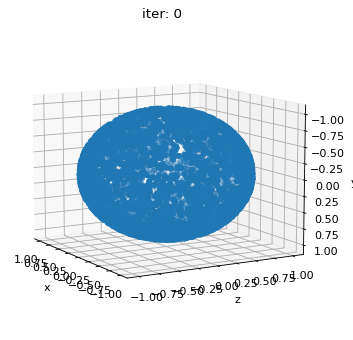

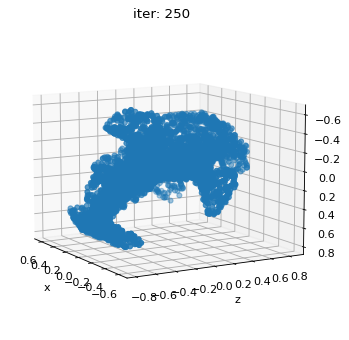

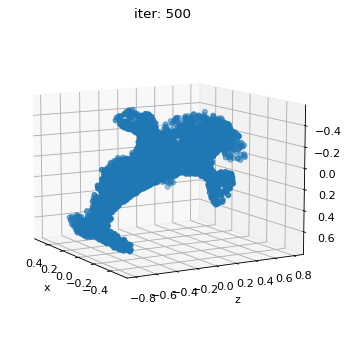

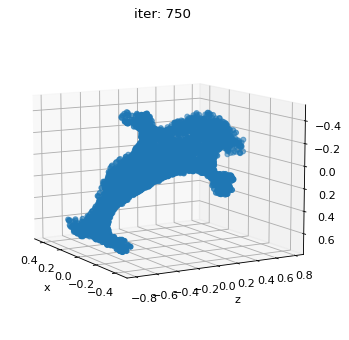

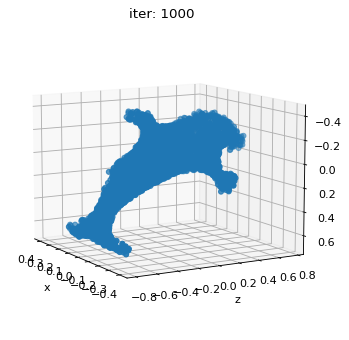

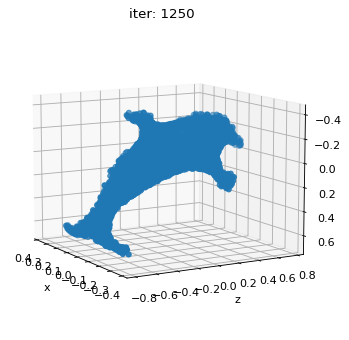

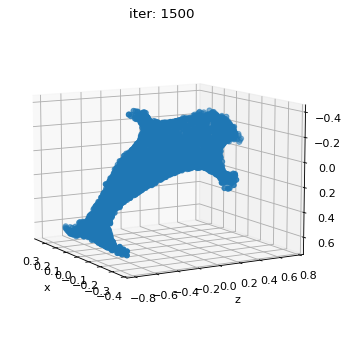

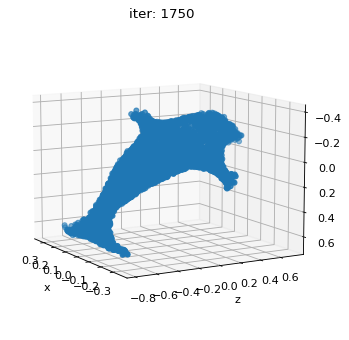

In [ ]:
# 2.4
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(2000,1,0,0,0)

  0%|          | 0/2000 [00:00<?, ?it/s]

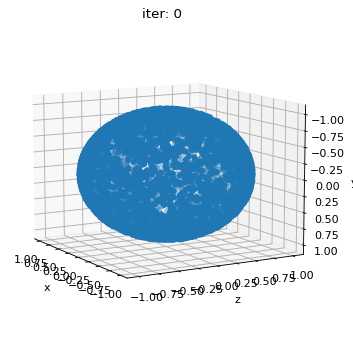

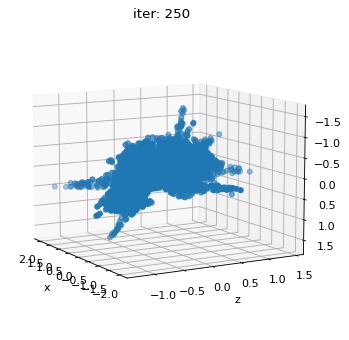

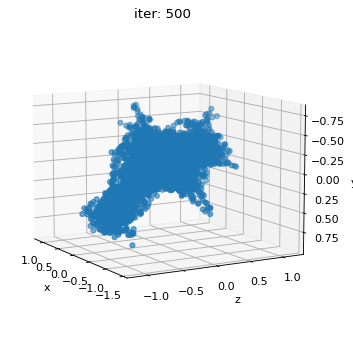

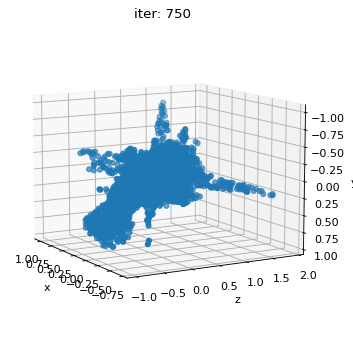

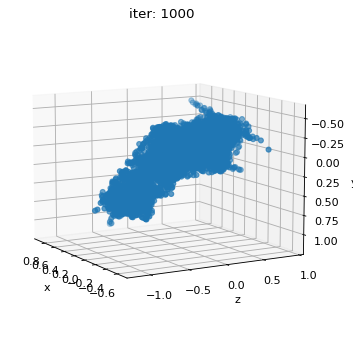

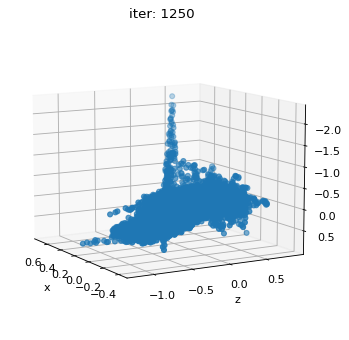

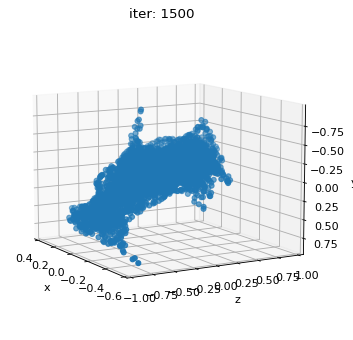

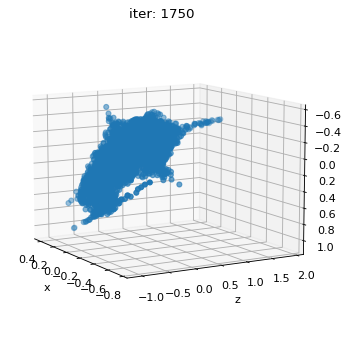

  0%|          | 0/2000 [00:00<?, ?it/s]

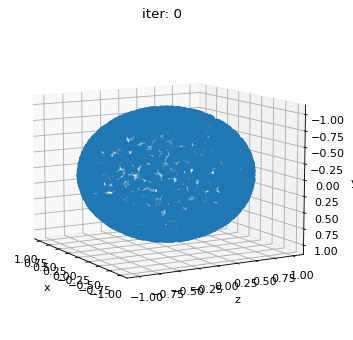

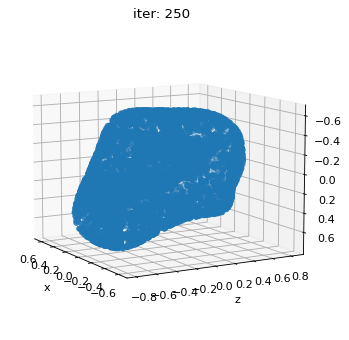

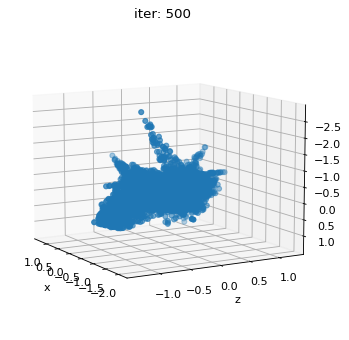

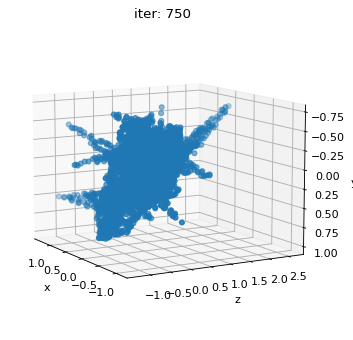

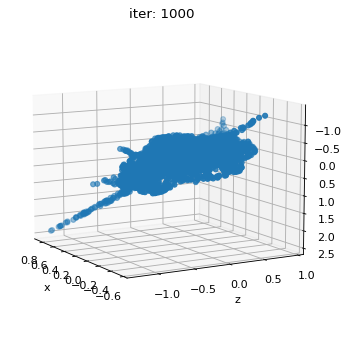

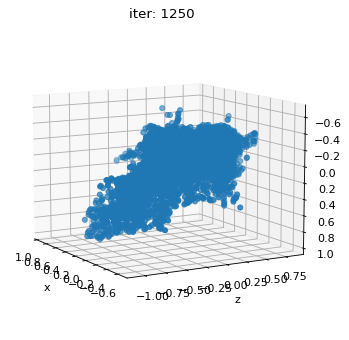

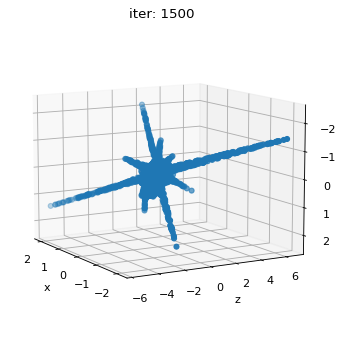

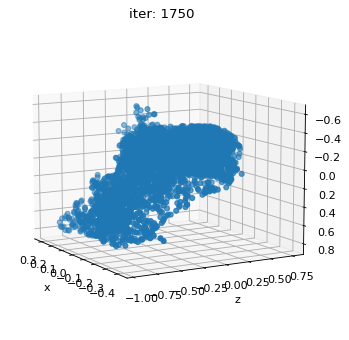

In [ ]:
# 2.4.Extension
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(2000,1,1,1,1)
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(2000,0.5,1,1,1)

  0%|          | 0/4000 [00:00<?, ?it/s]

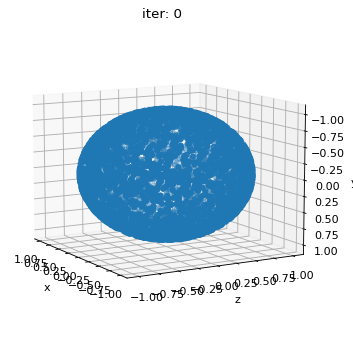

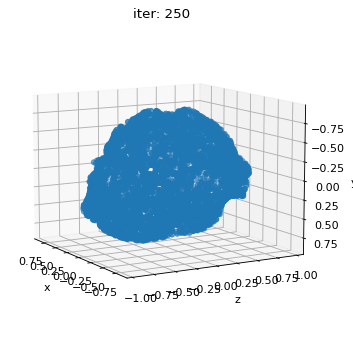

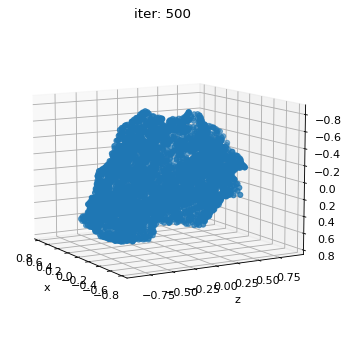

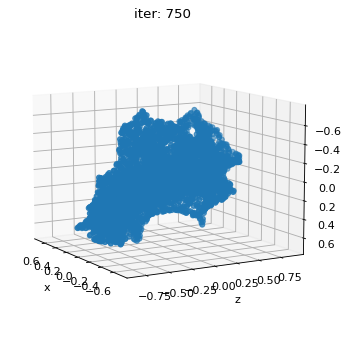

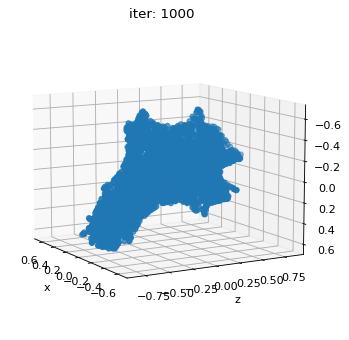

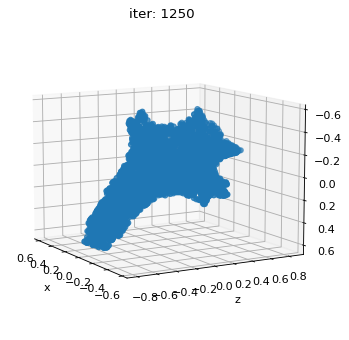

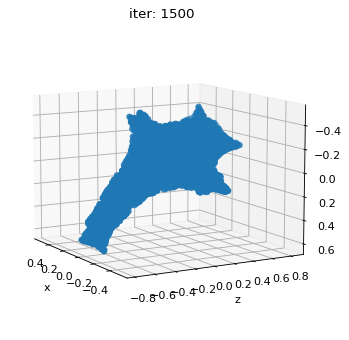

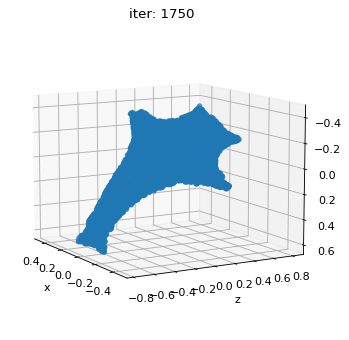

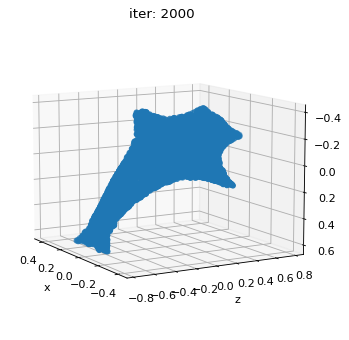

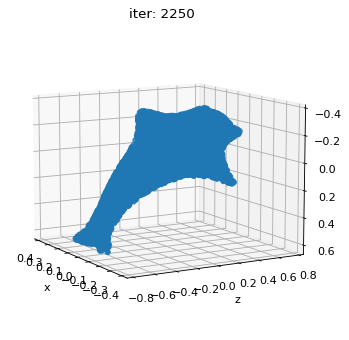

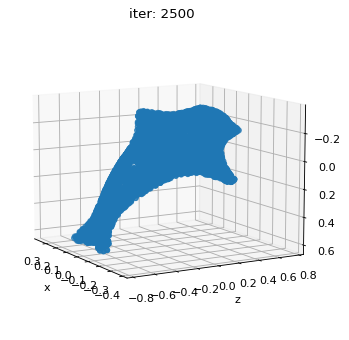

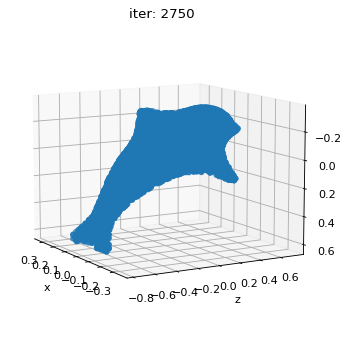

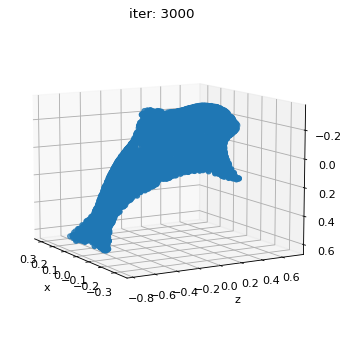

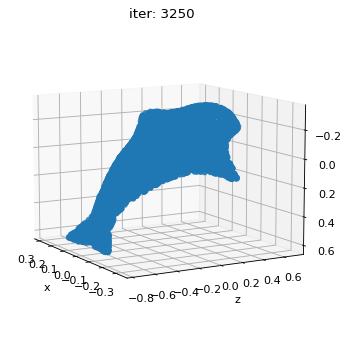

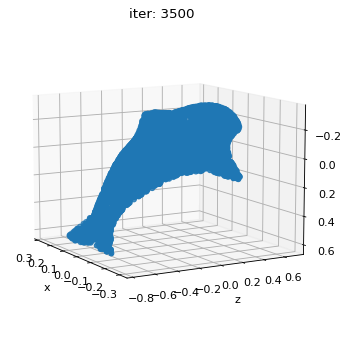

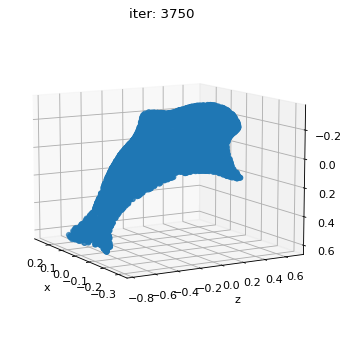

  0%|          | 0/4000 [00:00<?, ?it/s]

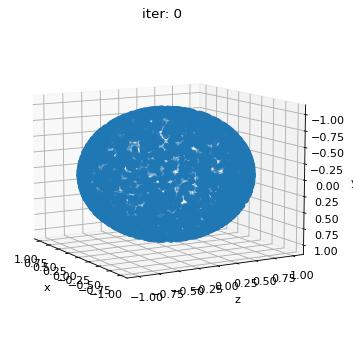

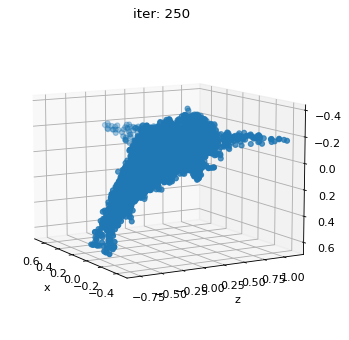

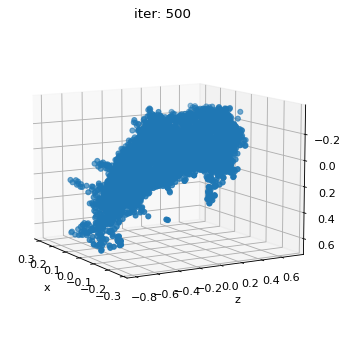

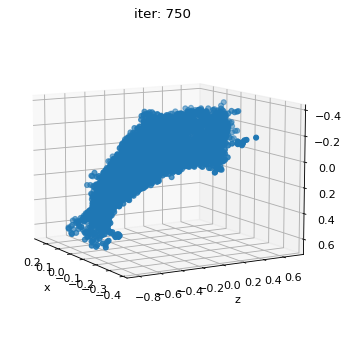

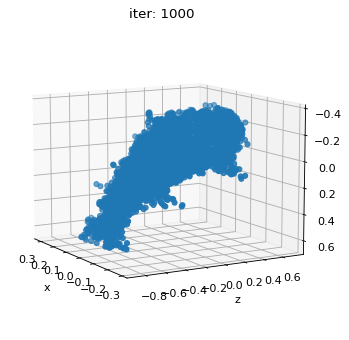

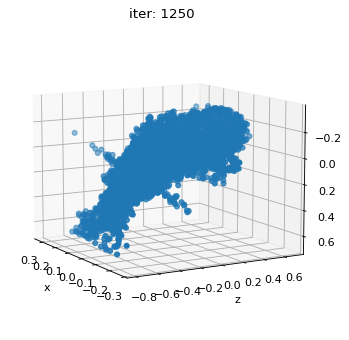

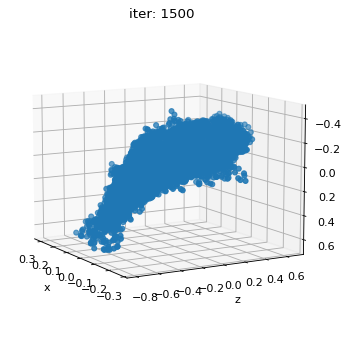

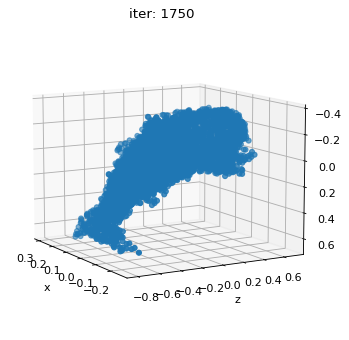

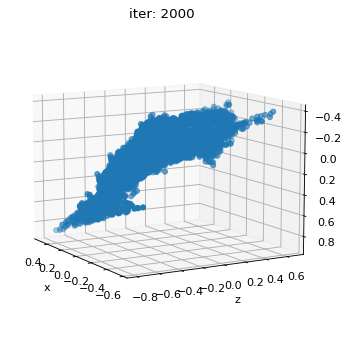

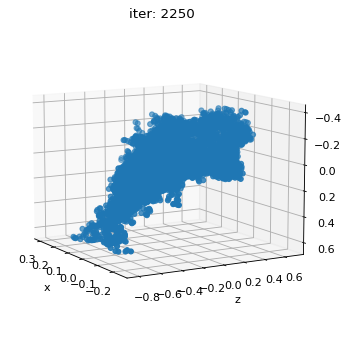

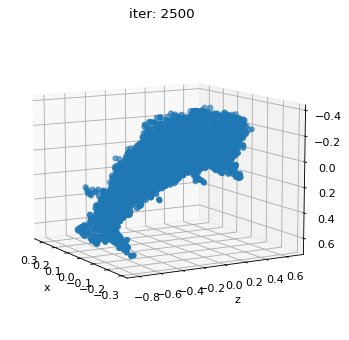

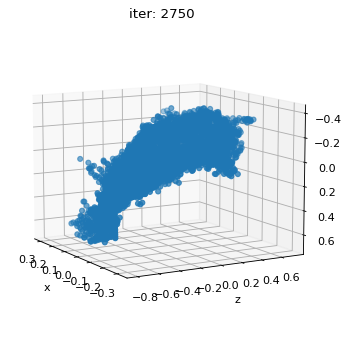

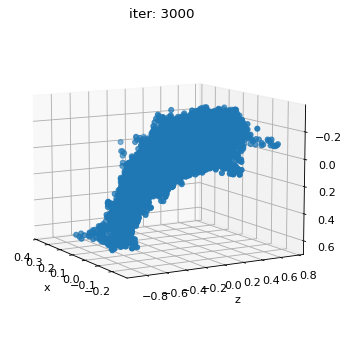

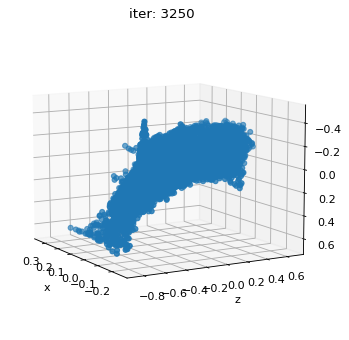

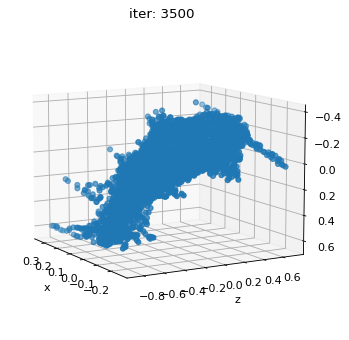

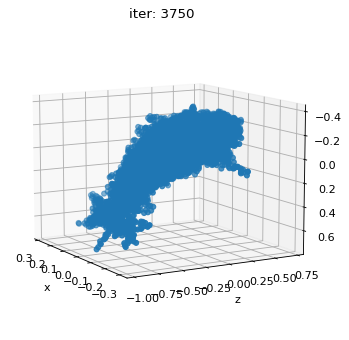

  0%|          | 0/4000 [00:00<?, ?it/s]

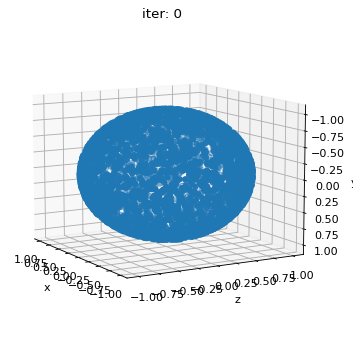

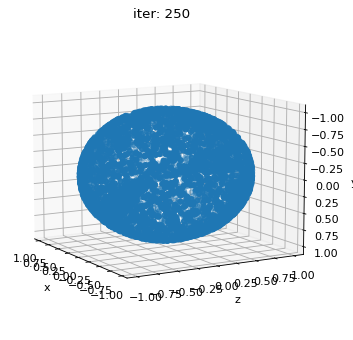

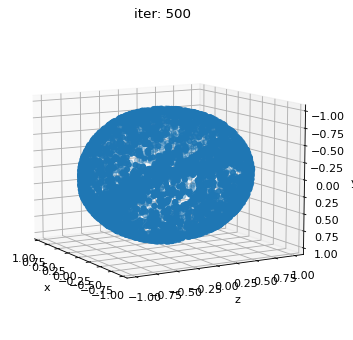

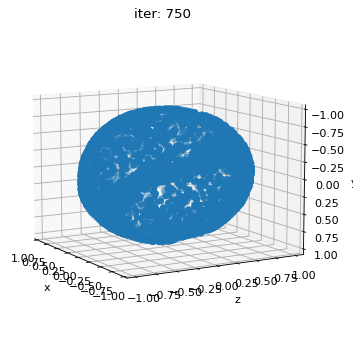

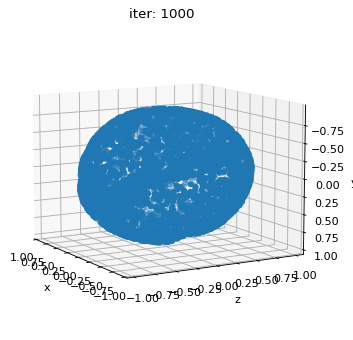

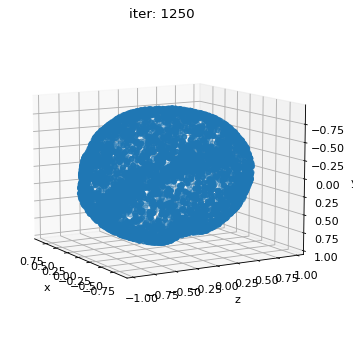

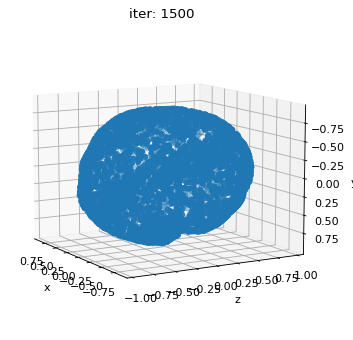

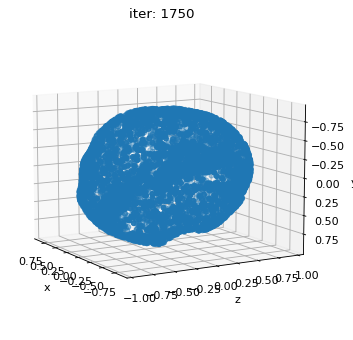

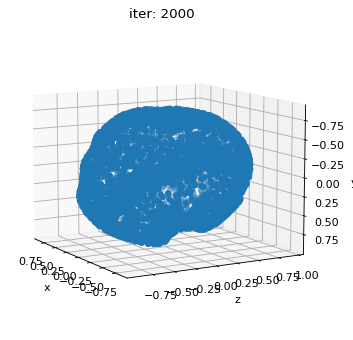

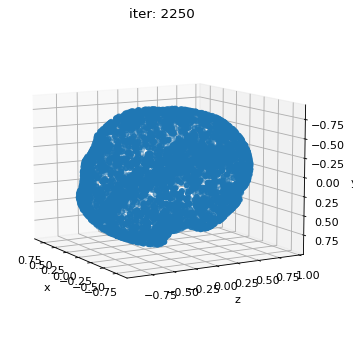

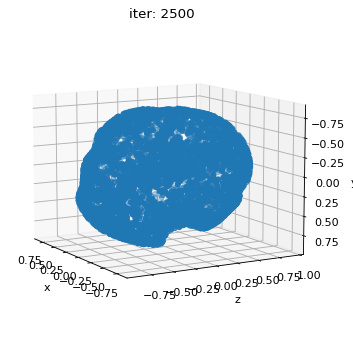

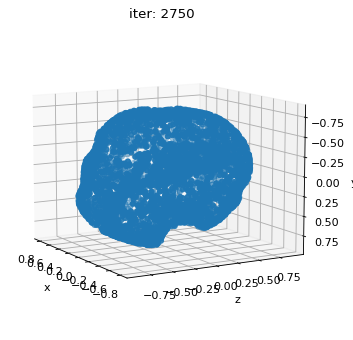

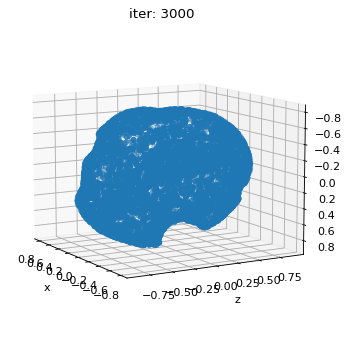

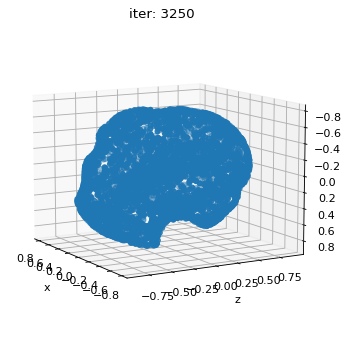

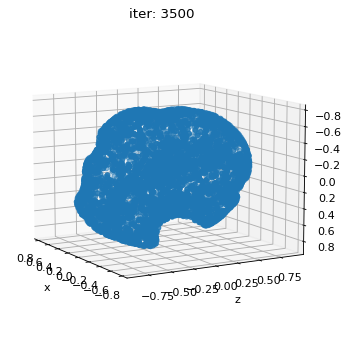

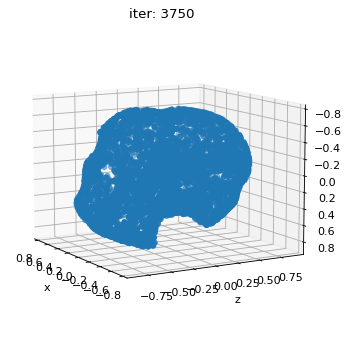

In [ ]:
# 2.5
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(optimizer_style=adam)
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(optimizer_style=rmsprop)
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(optimizer_style=sgd_second)

In [ ]:
# 1 1 0.1 0.001 RMS
# 1 1 0.05 0.43 ADAM
# these were also tested, to get optimals.

# 3. Experimenting with Other Shapes

In [26]:
# download the mug model - Mug by Microsoft is licensed under Creative Commons Attribution
# originally found at https://sketchfab.com/3d-models/mug-17c4808537f1448590378b3643c6da72
!wget https://raw.githubusercontent.com/hallpaz/3dsystems21/main/data/mug.obj

--2024-05-07 02:59:50--  https://raw.githubusercontent.com/hallpaz/3dsystems21/main/data/mug.obj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525932 (514K) [text/plain]
Saving to: ‘mug.obj’

mug.obj             100%[===================>] 513.61K  --.-KB/s    in 0.1s    

2024-05-07 02:59:51 (3.68 MB/s) - ‘mug.obj’ saved [525932/525932]



3.1 Is it possible to deform any mesh into another? Explain your thoughts.

3.2 Run the experiment again and try to deform a sphere into a mug.

3.3 Change the `src_mesh` to a `torus`. You can import the torus primitive from `pytorch3d.utils`. Now, try to deform the torus into a mug.


**[Extra] E.2 Run the experiments again using other shapes (either find and download shapes from the internet or create your own models).**

3.1. In theory, it is possible to deform one mesh into another through a series of transformations, but there are practical limitations and challenges to get a "good" deformation.

The topology of the two meshes must be compatible for deformation. If the meshes have significantly different topologies (e.g., different numbers of vertices, faces, or connectivity), it may not be straightforward to deform one into the other without introducing artifacts or discontinuities.

Deforming one mesh into another can also be computationally intensive, especially for high-resolution meshes or when employing sophisticated deformation techniques. Optimizing the deformation parameters to minimize the difference between the two meshes may require iterative optimization algorithms, which can be time-consuming.

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:548: UserWarning:

Mtl file does not exist: Mug.mtl



  0%|          | 0/4000 [00:00<?, ?it/s]

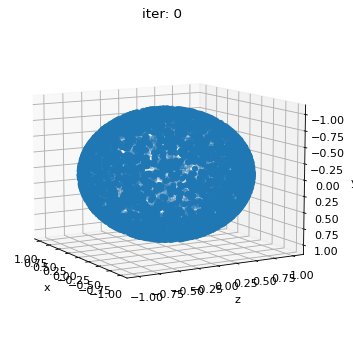

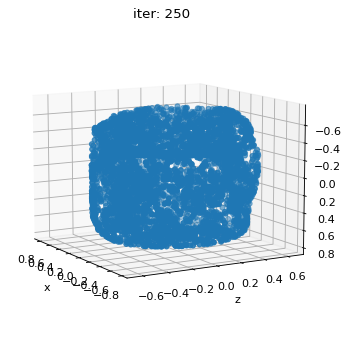

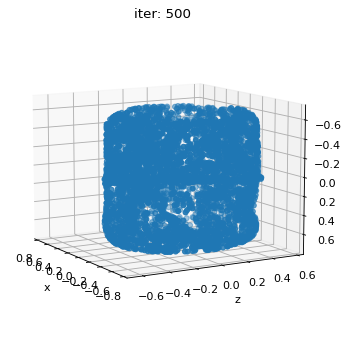

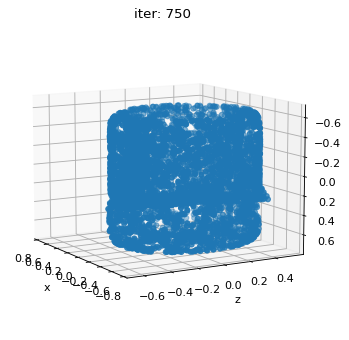

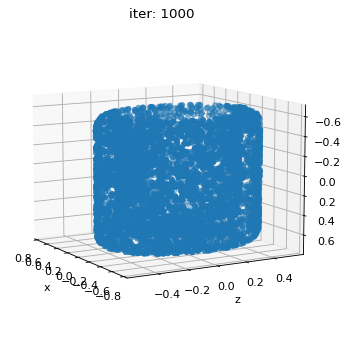

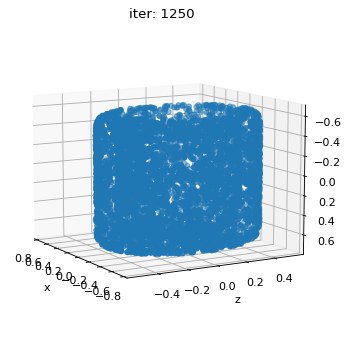

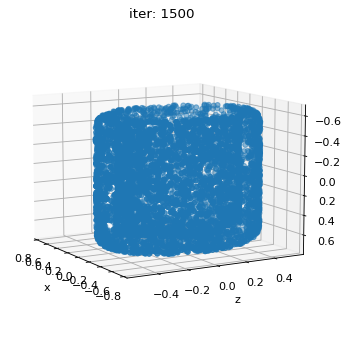

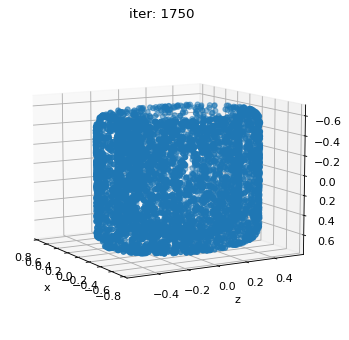

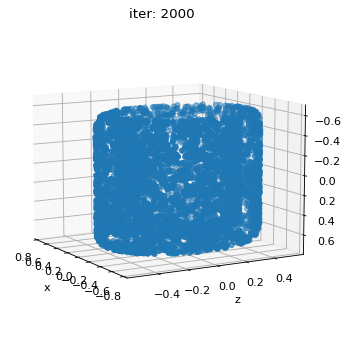

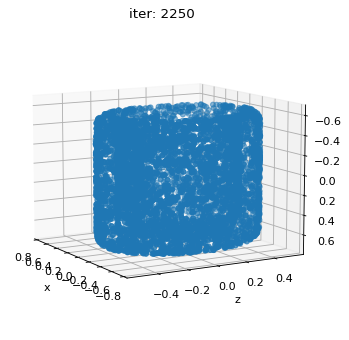

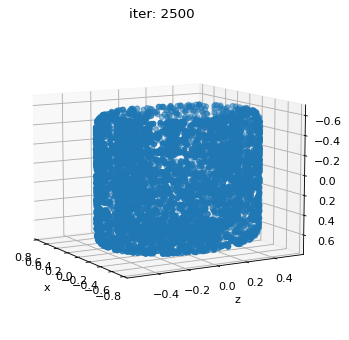

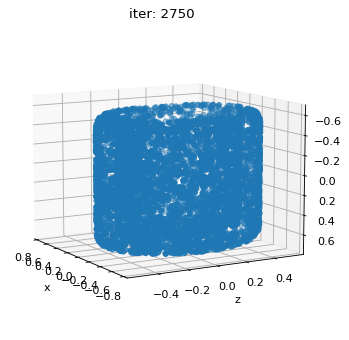

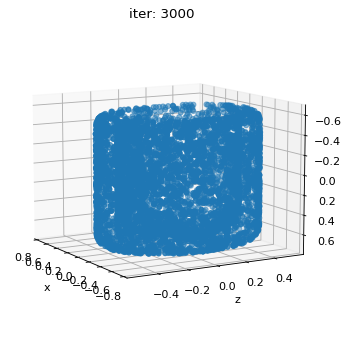

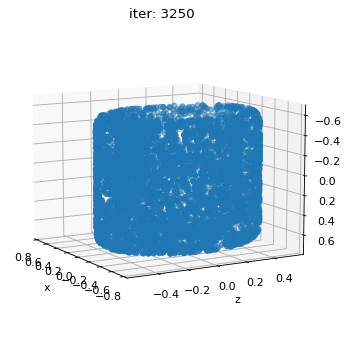

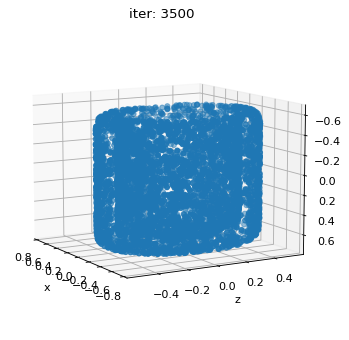

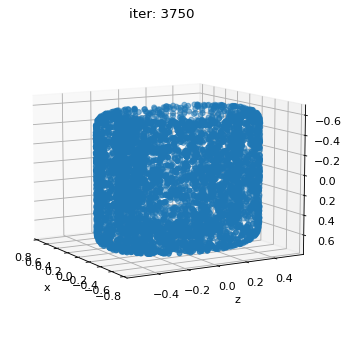

In [27]:
##############################################################################
# Code for 3.1 - 3.3
##############################################################################

# Load the MUG mesh.
trg_obj = os.path.join('mug.obj')

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

trg_mesh = normalize_mesh(verts, faces_idx)
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop()

  0%|          | 0/4000 [00:00<?, ?it/s]

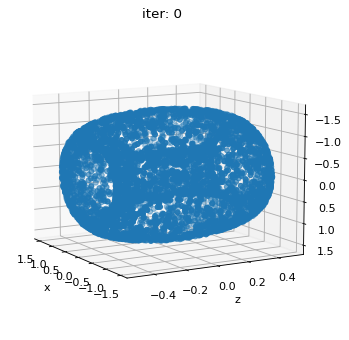

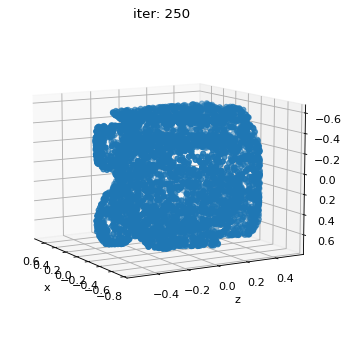

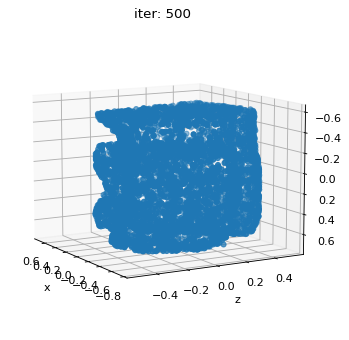

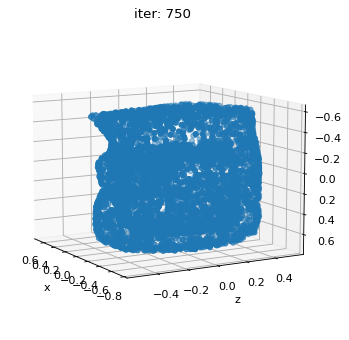

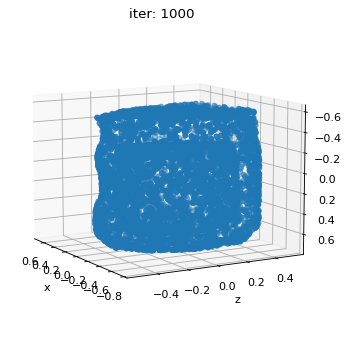

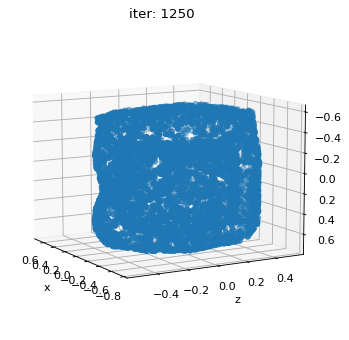

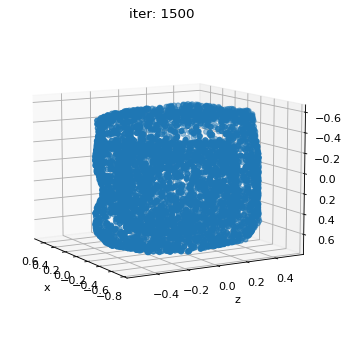

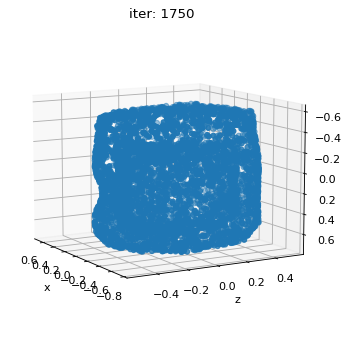

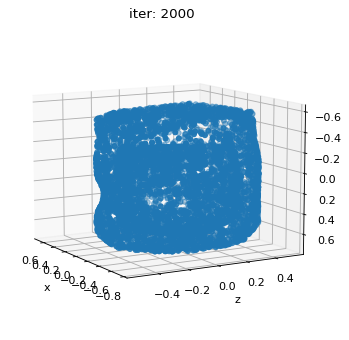

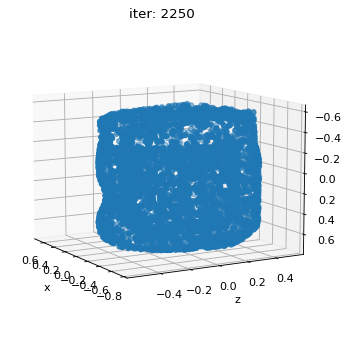

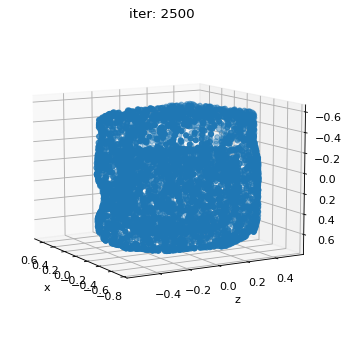

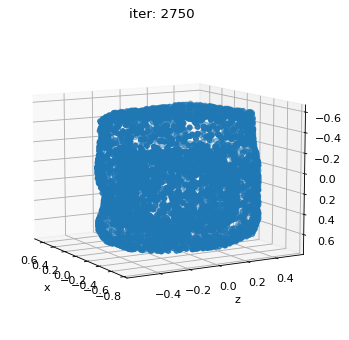

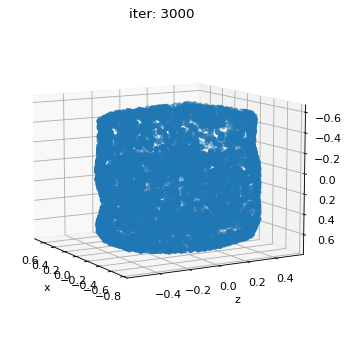

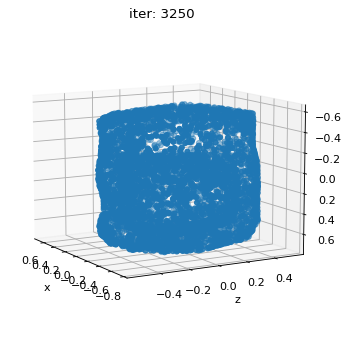

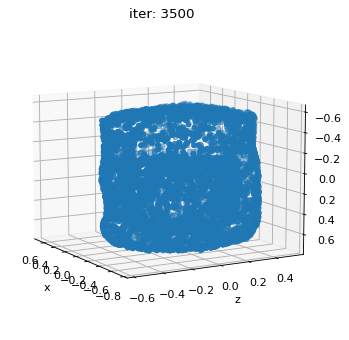

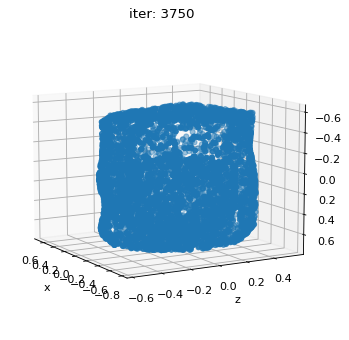

In [44]:
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(src_mesh_style=torus_stye)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning:

No mtl file provided



  0%|          | 0/4000 [00:00<?, ?it/s]

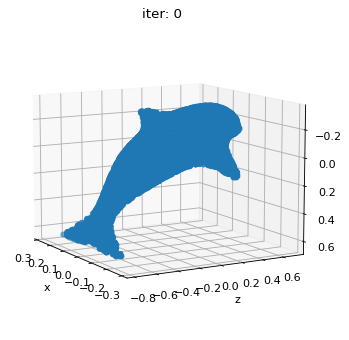

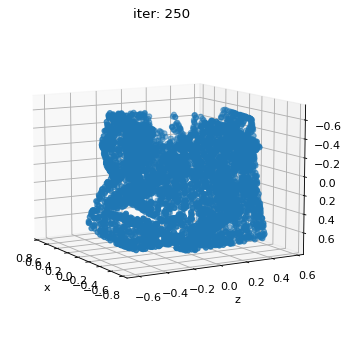

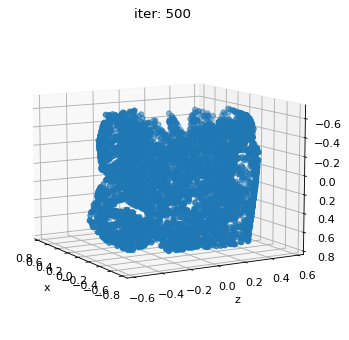

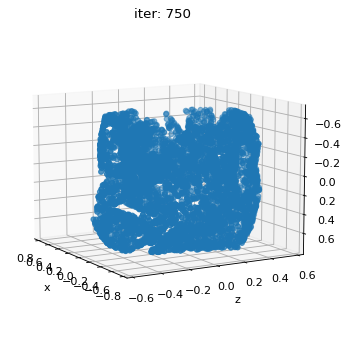

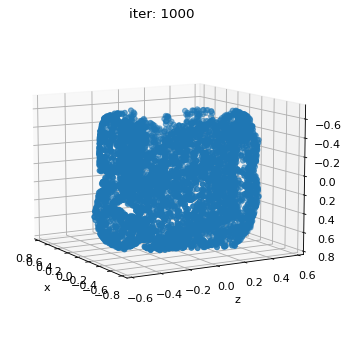

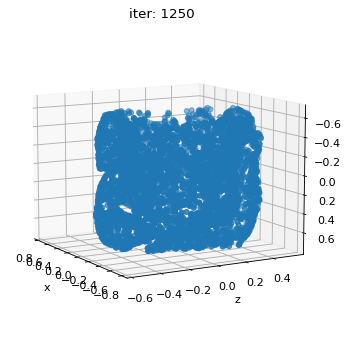

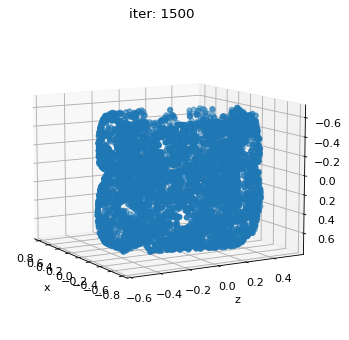

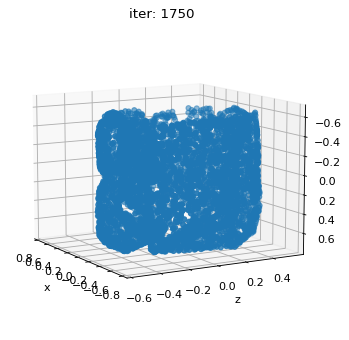

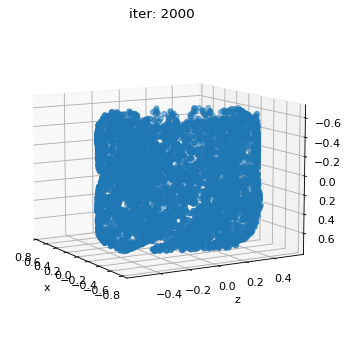

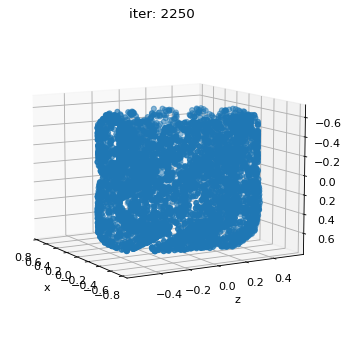

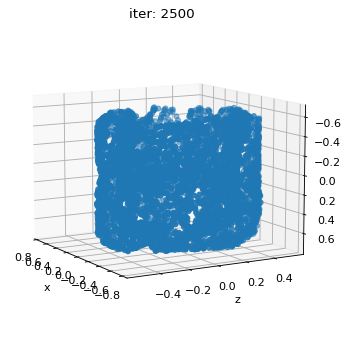

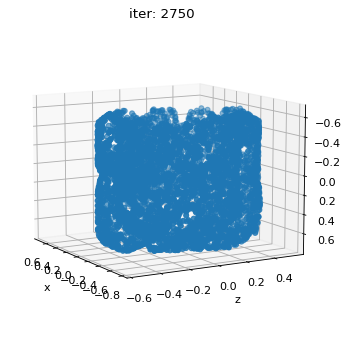

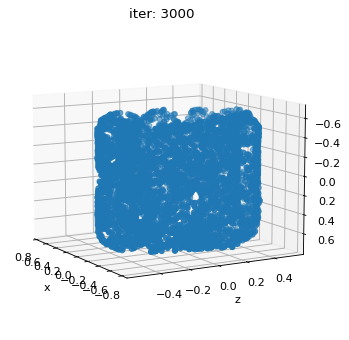

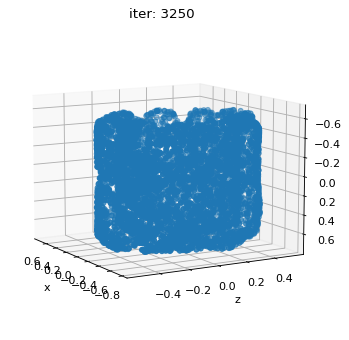

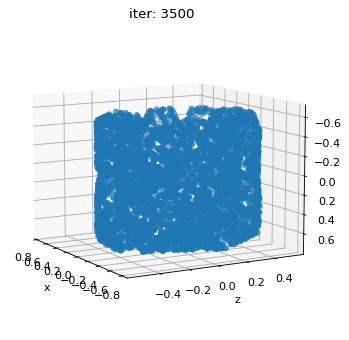

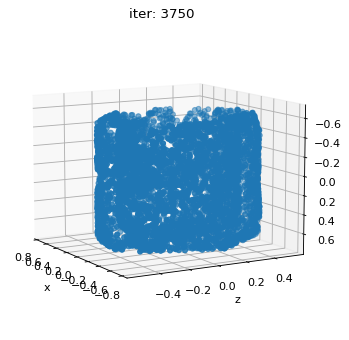

In [49]:
# Other shapes EXTENSION
# Hey, it's a dolphin and its trying to turn into a mugfin!
chamfer_losses, laplacian_losses, edge_losses, normal_losses = optimization_loop(src_mesh_style='other')

# 4. Food for Thoughts

Let's say you have a big set Ω of arbitrary meshes, and 1 mesh or a small set Δ of meshes, for example from the same class, that you are instered in. How would you solve the problem of fitting meshes from Ω to meshes in Δ?


To fit meshes from a large set Ω to meshes in a smaller set Δ, I would approach the problem as a shape matching or shape retrieval task. First, I would extract relevant features from both sets of meshes using techniques such as deep learning-based feature extraction or handcrafted feature descriptors. Then, I would employ a similarity metric or a machine learning model to measure the similarity between the features of meshes in Ω and Δ. Finally, I would use techniques such as nearest neighbor search or optimization algorithms to find the best-fitting meshes from Ω to those in Δ based on the computed similarity scores. This approach allows for efficient and scalable matching of meshes across different sets while leveraging learned or engineered representations of shape characteristics.